# Lane Detection Project

In this project you need to construct computer vision solution for a lane detection. We are going to implement [LaneNet](https://arxiv.org/pdf/1802.05591.pdf) paper. Our solution is going to have the following parts:

1. Lane semantic segmentation and metric learning
2. Instance segmentation over embedings
3. Homography prediction
4. Lane fitting

We are going to use [TuSimple](https://github.com/TuSimple/tusimple-benchmark/issues/3) dataset for a lane detection.

Let's discuss every step in details.

## Semantic and Instance Segmentation

In this part you should implement and train neural network with the 2 heads. The model should take as an input image and returns to masks. One head should predict *semantic segmentation* and another head should predict *embedding for each pixel*. Pixels that are part of one lane should have similar embeddings, on the other hand pixels from different lanes should have high distance between embeddings. In order to do that, we should implement *discriminative loss*.

After training the discribed network, we can threshold pixels of the interest and cluster them according to the embedding with the *DBSCAN*.

After solving the problem you should obtain the following result. 

## Homograpy Prediction

In order to solve the problem, we would like to understand an exact lane geometry. We are going to describe the lane with the 2-nd order polynom $ax^2 + bx + c$. 

In the image plane lines are not parallel and we may need higher order polynoms to discribe the lane geometry. In order to avoid that we could project image in the bird's eye view with the homography. But drivable surface has different properties over frames, so we would like to condition the homography on the image.

In order to do that, we going to train separate network to predict the best homography for each image.

## Lane Fitting

After predicting homography and lane's clustering we will fit 2-nd order polynom for each lane to obtain the final result. Lane fitting can be formulated as a least-squares problem, where we have points $\{x_i, y_i\}_{i=1}^n$ and we would like to estimation coefficients $a, b, c$ s.t.

$$
\sum_{i = 1}^n ||y_i - a x_i^2 - bx_i - c||^2 \rightarrow \min_{a, b,c}
$$



## Important Notes
0. During the project we provide the relevant papers. Reading the papers can be very helpful (and sometimes necessary) to implement the code.
1. During the project we provide you with the code templates that you should fill.
2. Homography Prediction and Instance Segmentation can be done in parallel.
3. You are free to use any other environment instead of Google Colab.
4. You can deviate from the original papers if it helps you to solve the problem, but you should explain your solution and motivation in the text block.

## Semantic and Segmentation Code

You can use the following commands to download the dataset and unpack it. But we suggest to upload the data to the Google Drive, with Google Drive you will be able to access the data much faster.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


We will shrink the dataset (11 GB → ~170 MB)

1. Download the TUSimple dataset:

In [2]:
!mkdir -p /data/tusimple
!wget -q --show-progress -- "https://s3.us-east-2.amazonaws.com/benchmark-frontend/datasets/1/train_set.zip"

train_set.zip       100%[===================>]  10.88G  12.8MB/s    in 14m 35s 


2. Extract all of them and delete all images except */20.jpg:

(https://github.com/sergey-ryzhikov/TusimpleUtils/blob/master/ShrinkTheDataset.md)

In [3]:
!unzip train_set.zip -d /data/tusimple 

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /data/tusimple/clips/0313-1/24060/19.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/18.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/17.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/16.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/15.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/14.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/13.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/12.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/11.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/10.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/9.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/8.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/7.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/6.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/5.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/4.jpg  
  inflating: /data/tusimple/clips/0313-1/2

In [ ]:
!find /data/tusimple/ -name "*.jpg" -not -name "20.jpg" -delete   # keep only 20.jpg

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /data/tusimple/clips/0313-1/24060/19.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/18.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/17.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/16.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/15.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/14.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/13.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/12.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/11.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/10.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/9.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/8.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/7.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/6.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/5.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/4.jpg  
  inflating: /data/tusimple/clips/0313-1/2

3. Move files to google drive folder 

In [ ]:
!mv "/data/tusimple/" "/content/gdrive/MyDrive/Colab Notebooks/CV/"

In [ ]:
!ls "/content/gdrive/MyDrive/Colab Notebooks/CV/tusimple"

clips		      label_data_0531.json  readme.md
label_data_0313.json  label_data_0601.json


In the following cell you should implement pytorch Dataset to generate training examples for instance and semantic segmentation. You are able to modify the signatures if you want.

To implement the LaneDataset you should become familiar with the labeling format.

The dataset is relatively small, so it is important to implement different augmentation strategies. We suggest to use random flips and color augmentations (brightness, saturation). You can also use augmentations of your choice. Augmentations are not required to obtain a full grade but without them your model could overfit dramatically.

NOTE: It can be useful to generate binary segmentation and instance segmentation ground truth once and then use it as-is in every experiment.

In [4]:
# https://github.com/ShenhanQian/Lane_Detection-An_Instance_Segmentation_Approach/dataset.py

import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
import cv2
import json
from albumentations import Compose, HorizontalFlip, OneOf, OpticalDistortion, RandomBrightnessContrast, RandomGamma


class LaneDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, dataset_dir, phase, size=(512,256), transform=None):
        """
        Args:
            dataset_dir: The directory path of the dataset
            phase: 'train', 'val', or 'test'
        """
        self.dataset_dir = dataset_dir
        self.phase = phase
        self.size = size
        self.transform = transform
        assert os.path.exists(dataset_dir), 'Directory {} does not exist!'.format(dataset_dir)
     
        
        if phase == 'train' or phase == 'val':
            label_files = list()
            
            if phase == 'train':
                label_files.append(os.path.join(dataset_dir, 'label_data_0313.json'))
                label_files.append(os.path.join(dataset_dir, 'label_data_0531.json'))
            elif phase == 'val':
                label_files.append(os.path.join(dataset_dir, 'label_data_0601.json'))

            
            self.image_list = []
            self.lanes_list = []
            for file in label_files:
                try:
                    for line in open(file).readlines():
                        info_dict = json.loads(line)
                        self.image_list.append(info_dict['raw_file'])

                        h_samples = info_dict['h_samples']
                        lanes = info_dict['lanes']
                        xy_list = list()

                        for lane in lanes:
                            y = np.array([h_samples]).T
                            x = np.array([lane]).T
                            xy = np.hstack((x, y))
                            index = np.where(xy[:, 0] > 2)
                            xy_list.append(xy[index])
                        self.lanes_list.append(xy_list)
                except BaseException:
                    raise Exception(f'Fail to load {file}.')

  
    def __getitem__(self, idx):
  
        if self.phase == 'train' or self.phase == 'val':
            img_path = os.path.join(self.dataset_dir, self.image_list[idx])
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)
            h, w, c = image.shape
            image = cv2.resize(image, self.size, interpolation=cv2.INTER_LINEAR)

            if self.phase == "train":
                if self.transform:
                    img = self.transform(image)
                else:
                    aug = Compose([OneOf([HorizontalFlip(p=0.5), RandomBrightnessContrast(always_apply=False, p=0.3, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
                                    RandomGamma(always_apply=False, p=0.3, gamma_limit=(70, 130)),], p=0.4,),
                            OneOf([OpticalDistortion(always_apply=False, p=0.3, distort_limit=(-0.1, 0.1), shift_limit=(-0.1, 0.1), interpolation=0, border_mode=0),], p=0.3)])
            else:
                aug = Compose([])

            bin_seg_label = np.zeros((h, w), dtype=np.uint8)
            inst_seg_label = np.zeros((h, w), dtype=np.uint8)
            lanes = self.lanes_list[idx]

            for idx, lane in enumerate(lanes):
                cv2.polylines(bin_seg_label, [lane], False, 1, 10)
                cv2.polylines(inst_seg_label, [lane], False, idx + 1, 10)

            bin_seg_label = cv2.resize(bin_seg_label, self.size, interpolation=cv2.INTER_NEAREST)
            inst_seg_label = cv2.resize(inst_seg_label, self.size, interpolation=cv2.INTER_NEAREST)

            bin_seg_label = np.broadcast_to(bin_seg_label[..., None], bin_seg_label.shape + (3,))
            inst_seg_label = np.broadcast_to(inst_seg_label[..., None], inst_seg_label.shape + (3,))

            augmented = aug(image=image, masks=[bin_seg_label, inst_seg_label])

            image = augmented["image"]
            bin_seg_label = augmented["masks"][0]
            inst_seg_label = augmented["masks"][1]

            image = torch.from_numpy(image).float()
            bin_seg_label = bin_seg_label[:, :, 0]
            inst_seg_label = inst_seg_label[:, :, 0]

            bin_seg_label = torch.from_numpy(bin_seg_label.copy())
            inst_seg_label = torch.from_numpy(inst_seg_label.copy())

            image = np.transpose(image, (2, 0, 1))

            return image, bin_seg_label, inst_seg_label

       
    def __len__(self):
        return len(self.image_list)

In [5]:
dataset_path = "/content/gdrive/MyDrive/Colab Notebooks/CV/tusimple"
train_set = LaneDataset(dataset_path, phase="train")
val_set = LaneDataset(dataset_path, phase="val")

batch_size = 8

In [6]:
def build_sampler(train_set, val_set, batch_size):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)
    return {"train": train_loader, "val": val_loader}

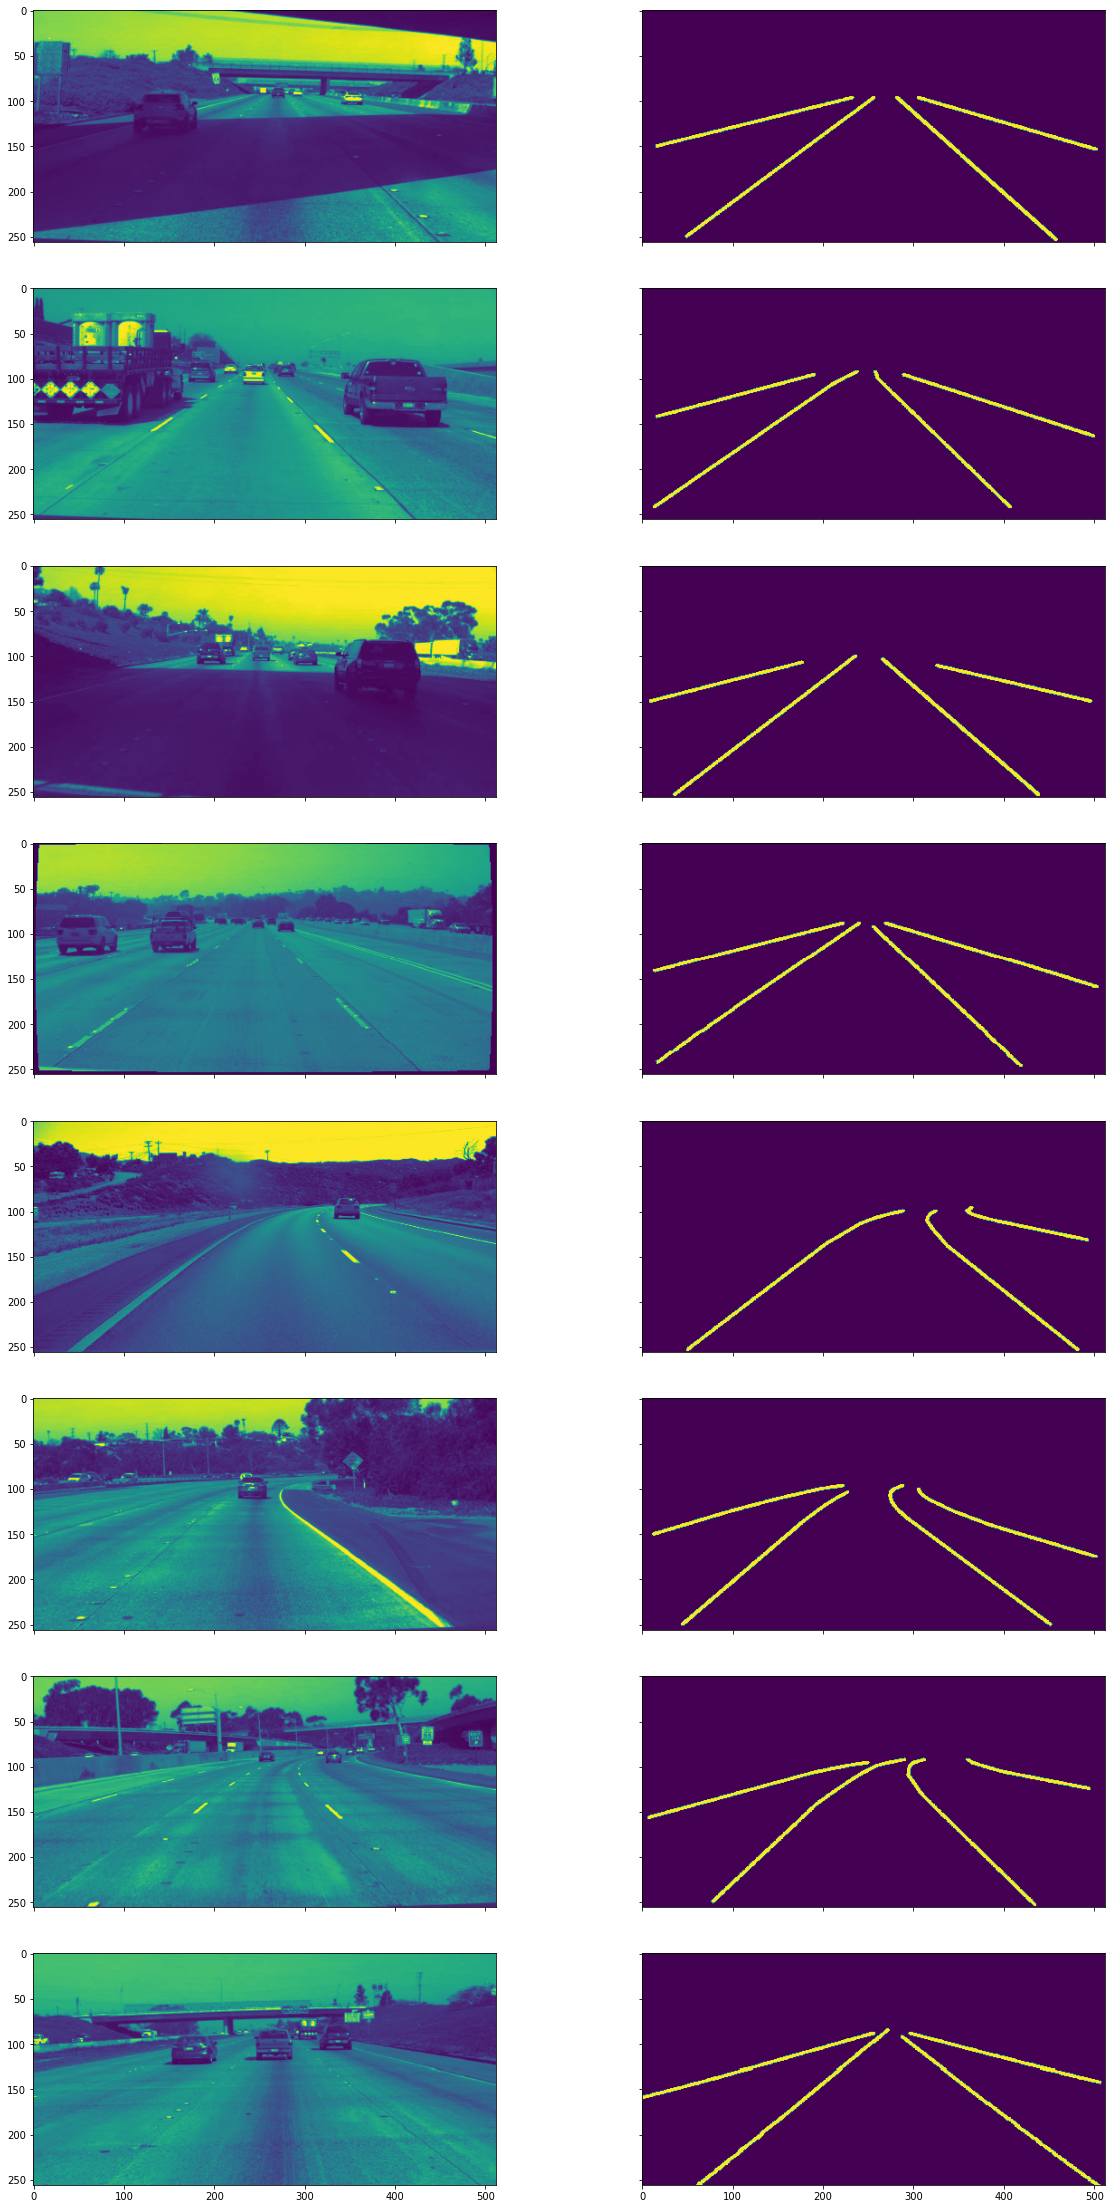

In [7]:
from functools import reduce
import matplotlib.pyplot as plt


dataloaders = build_sampler(train_set, val_set, batch_size)

image, mask, ins_mask = next(iter(dataloaders["train"]))

images = image[:, 0, :, :]
masks = mask[:, :, :]

input_images_rgb = [x for x in images]
target_masks_rgb = [x for x in masks]

img_arrays = [input_images_rgb, target_masks_rgb]

images = reduce(lambda x, y: x + y, zip(*img_arrays))

_, ax = plt.subplots(len(images) // 2, 2, sharex="all", sharey="all", figsize=(20, 40))
for i in range(len(images)):
    ax[i // 2, i % 2]
    ax[i // 2, i % 2].imshow(images[i])

For this task we are going to use ENet architecture. You can read the description in the [original paper](https://arxiv.org/pdf/1606.02147.pdf).

To generate two different outputs we need to have two different branches. In the LaneNet paper authers proposed to share only two first sections of the encoder between to tasks. Third section and decoder should be separate for the instance segmentation and binary segmentation problem.

The output dimension of the instance segmentation embedding should be equal to 5.

In [8]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2

from collections import defaultdict

ENet architecture.
*   initial 16 × 256 × 256
*   bottleneck1.0 downsampling 64 × 128 × 128
*   4× bottleneck1.x 64 × 128 × 128
*   bottleneck2.0 downsampling 128 × 64 × 64
*   bottleneck2.1 128 × 64 × 64
*   bottleneck2.2 dilated 2 128 × 64 × 64
*   bottleneck2.3 asymmetric 5 128 × 64 × 64
*   bottleneck2.4 dilated 4 128 × 64 × 64
*   bottleneck2.5 128 × 64 × 64
*   bottleneck2.6 dilated 8 128 × 64 × 64
*   bottleneck2.7 asymmetric 5 128 × 64 × 64
*   bottleneck2.8 dilated 16 128 × 64 × 64
*   Repeat section 2, without bottleneck2.0
*   bottleneck4.0 upsampling 64 × 128 × 128
*   bottleneck4.1 64 × 128 × 128
*   bottleneck4.2 64 × 128 × 128
*   bottleneck5.0 upsampling 16 × 256 × 256
*   bottleneck5.1 16 × 256 × 256
*   fullconv C × 512 × 512

In [9]:
# https://github.com/IvanVassi/LaneNet-with-homography/blob/main/model.py

'''
The initial stage contains a single block.
ENet initial block. MaxPooling is performed with non-overlapping 2 × 2 windows,
and the convolution has 13 filters, which sums up to 16 feature maps after concatenation.
ENet bottleneck module. conv is either a regular, dilated, or full convolution 
(also known as deconvolution) with 3 × 3 filters, or a 5 × 5 convolution decomposed
into two asymmetric ones.

https://arxiv.org/pdf/1606.02147.pdf
'''

class Initial(nn.Module):    

    """ENet initial block""" 
    
    def __init__(self):
        super(Initial, self).__init__()
        self.net = nn.ModuleList([nn.Sequential(nn.Conv2d(3, 13, 2, stride=2), 
                                                nn.PReLU(),
                                                nn.BatchNorm2d(13)),
                                   nn.MaxPool2d(2)])

    def forward(self, x):
        y = x
        x = self.net[0](x)
        y = self.net[1](y)
        return torch.cat([x, y], dim=1)

In [10]:
# https://github.com/IvanVassi/LaneNet-with-homography/blob/main/model.py

class Bottleneck(nn.Module):
    def __init__(self, in_ch, out_ch,  dropout_prob,  module_type="downsampling", padding=0, ratio=2):
        super(Bottleneck, self).__init__()

        self.__module_type = module_type
        
        '''
        Early downsampling One crucial intuition to achieving good performance and real-time operation
        is realizing that processing large input frames is very expensive. This might sound very obvious,
        however many popular architectures do not to pay much attention to optimization of early stages of
        the network, which are often the most expensive by far.
        ENet first two blocks heavily reduce the input size, and use only a small set of feature maps. The
        idea behind it, is that visual information is highly spatially redundant, and thus can be compressed
        into a more efficient representation. Also, our intuition is that the initial network layers should not
        directly contribute to classification. Instead, they should rather act as good feature extractors and only
        preprocess the input for later portions of the network. This insight worked well in our experiments;
        increasing the number of feature maps from 16 to 32 did not improve accuracy on Cityscapes [14]
        dataset.
        '''

        if self.__module_type == "downsampling":
            self.__net = nn.ModuleDict({"block1": nn.Sequential(nn.Conv2d(in_ch, out_ch, 2, stride=2), 
                                                                nn.PReLU(), 
                                                                nn.BatchNorm2d(out_ch)),
                                        "block2": nn.Sequential(nn.Conv2d(out_ch, out_ch, 3, padding=padding),
                                                                nn.PReLU(), 
                                                                nn.BatchNorm2d(out_ch)),
                                        "block3": nn.Sequential(nn.Conv2d(out_ch, out_ch, 1),
                                                                nn.PReLU(), 
                                                                nn.BatchNorm2d(out_ch)),
                                        "dropout": nn.Dropout2d(p=dropout_prob),
                                        "pooling": nn.MaxPool2d(2),
                                        "1*1": nn.Conv2d(in_ch, out_ch, 1)})

        elif self.__module_type.split()[0] == "asymmetric":
            self.__net = nn.ModuleDict({"block1": nn.Sequential(nn.Conv2d(in_ch, in_ch // ratio, 1),
                                                                nn.PReLU(),
                                                                nn.BatchNorm2d(in_ch // ratio)),
                                        "block2": nn.Sequential(nn.Sequential(nn.Conv2d(in_ch // ratio, in_ch // ratio, (5, 1), padding=(2, 0)),
                                                                nn.Conv2d(in_ch // ratio, in_ch // ratio, (1, 5), padding=(0, 2))),
                                                                nn.PReLU(),
                                                                nn.BatchNorm2d(in_ch // ratio)),
                                        "block3": nn.Sequential(nn.Conv2d(in_ch // ratio, out_ch, 1),
                                                                nn.PReLU(),
                                                                nn.BatchNorm2d(out_ch)),
                                        "dropout": nn.Dropout2d(p=dropout_prob)})

        elif self.__module_type.split()[0] == "dilated":
            self.__net = nn.ModuleDict({"block1": nn.Sequential(nn.Conv2d(in_ch, in_ch // ratio, 1),
                                                                nn.PReLU(),
                                                                nn.BatchNorm2d(in_ch // ratio)),
                                        "block2": nn.Sequential(nn.Conv2d(in_ch // ratio, in_ch // ratio, 3, dilation=int(module_type.split()[1]), padding=padding),
                                                                nn.PReLU(),
                                                                nn.BatchNorm2d(in_ch // ratio)),
                                        "block3": nn.Sequential(nn.Conv2d(in_ch // ratio, out_ch, 1),
                                                                nn.PReLU(),
                                                                nn.BatchNorm2d(out_ch)),
                                        "dropout": nn.Dropout2d(p=dropout_prob)})
            
        elif self.__module_type == "normal":
            self.__net = nn.ModuleDict({"block1": nn.Sequential(nn.Conv2d(in_ch, in_ch // ratio, 1),
                                                                nn.PReLU(),
                                                                nn.BatchNorm2d(in_ch // ratio),),
                                        "block2": nn.Sequential(nn.Conv2d(in_ch // ratio, in_ch // ratio, 3, padding=padding),
                                                                nn.PReLU(),
                                                                nn.BatchNorm2d(in_ch // ratio),),
                                        "block3": nn.Sequential(nn.Conv2d(in_ch // ratio, out_ch, 1),
                                                                nn.PReLU(),
                                                                nn.BatchNorm2d(out_ch),),
                                        "dropout": nn.Dropout2d(p=dropout_prob),})
            
        elif self.__module_type == "upsampling":
            self.__net = nn.ModuleDict({"block1": nn.Sequential(nn.Conv2d(in_ch, in_ch // ratio, 1),
                                                                nn.PReLU(),
                                                                nn.BatchNorm2d(in_ch // ratio),),
                                        "block2": nn.Sequential(nn.ConvTranspose2d(in_ch // ratio, in_ch // ratio, 2, stride=2, padding=padding),
                                                                nn.PReLU(),
                                                                nn.BatchNorm2d(in_ch // ratio),),
                                        "block3": nn.Sequential(nn.Conv2d(in_ch // ratio, out_ch, 1),
                                                                nn.PReLU(),
                                                                nn.BatchNorm2d(out_ch),),  
                                        "block4": nn.Conv2d(in_ch, out_ch, 1),
                                        "dropout": nn.Dropout2d(p=dropout_prob),})

    def forward(self, x, prev=None):
        y = x
        if self.__module_type == "downsampling":
            x = self.__net["block1"](x)
            x = self.__net["block2"](x)
            x = self.__net["block3"](x)
            x = self.__net["dropout"](x)
            y = self.__net["pooling"](y)
            y = self.__net["1*1"](y)

            return x + y
        else:
            x = self.__net["block1"](x)
            x = self.__net["block2"](x)
            x = self.__net["block3"](x)
            x = self.__net["dropout"](x)
            if self.__module_type == "upsampling":
                return x + prev
            return x + y

In [11]:
class RepeatBlock(nn.Sequential):
    def __init__(self, in_ch, out_ch):
        super(RepeatBlock, self).__init__()

        self.add_module("Bottleneck_1", Bottleneck(in_ch, out_ch, 0.1, module_type="normal", padding=1))
        self.add_module("Bottleneck_2", Bottleneck(out_ch, out_ch, 0.1, module_type="dilated 2", padding=2))
        self.add_module("Bottleneck_3", Bottleneck(out_ch, out_ch, 0.1, module_type="asymmetric"))
        self.add_module("Bottleneck_4", Bottleneck(out_ch, out_ch, 0.1, module_type="dilated 4", padding=4))
        self.add_module("Bottleneck_5", Bottleneck(out_ch, out_ch, 0.1, module_type="normal", padding=1))
        self.add_module("Bottleneck_6", Bottleneck(out_ch, out_ch, 0.1, module_type="dilated 8", padding=8))
        self.add_module("Bottleneck_7", Bottleneck(out_ch, out_ch, 0.1, module_type="asymmetric"))
        self.add_module("Bottleneck_8", Bottleneck(out_ch, out_ch, 0.1, module_type="dilated 16", padding=16))

In [12]:
class SharedEncoder(nn.Module):
    def __init__(self):
        super(SharedEncoder, self).__init__()
        self.__initial = Initial()
        self.__downsample = nn.ModuleDict({"downsample_1": Bottleneck(16, 64, 0.01, padding=1),
                                           "downsample_2": Bottleneck(64, 128, 0.1, padding=1)})
        self.__net = nn.Sequential(Bottleneck(64, 64, 0.01, module_type="normal", padding=1),
                                   Bottleneck(64, 64, 0.01, module_type="normal", padding=1),
                                   Bottleneck(64, 64, 0.01, module_type="normal", padding=1),
                                   Bottleneck(64, 64, 0.01, module_type="normal", padding=1))
        self.__tail = RepeatBlock(128, 128)

    def forward(self, x):
        prevs = []
        x = self.__initial(x)
        prevs.append(x)
        x = self.__downsample["downsample_1"](x)
        prevs.append(x)
        x = self.__net(x)
        x = self.__downsample["downsample_2"](x)
        x = self.__tail(x)
        return x, prevs


In [13]:
# https://github.com/IvanVassi/LaneNet-with-homography/blob/main/model.py

class Decoder(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch, final_ch):
        super(Decoder, self).__init__()
        self.__upsample = nn.ModuleDict({"upsample_1": Bottleneck(in_ch, mid_ch, 0.1, module_type="upsampling"),
                                         "upsample_2": Bottleneck(mid_ch, out_ch, 0.1, module_type="upsampling")})
        
        self.__net = nn.ModuleDict({"normal_1": Bottleneck(mid_ch, mid_ch, 0.1, module_type="normal", padding=1),
                                    "normal_2": Bottleneck(mid_ch, mid_ch, 0.1, module_type="normal", padding=1)})
        
        self.__end = nn.Sequential(nn.ConvTranspose2d(out_ch, final_ch, 2, stride=2))

    def forward(self, x, y):
        x = self.__upsample["upsample_1"](x, y[1])
        x = self.__net["normal_1"](x)
        x = self.__net["normal_2"](x)
        x = self.__upsample["upsample_2"](x, y[0])
        x = self.__end(x)
        return x

In [14]:
class Embedding(nn.Module):
    def __init__(self, emb_size):
        super(Embedding, self).__init__()
        self.__net = nn.ModuleDict({"repeat": RepeatBlock(128, 128),
                                    "decoder": Decoder(128, 64, 16, emb_size)})

    def forward(self, x, prevs):
        x = self.__net["repeat"](x)
        x = self.__net["decoder"](x, prevs)
        return x


In [15]:
class Segmentation(nn.Module):
    def __init__(self):
        super(Segmentation, self).__init__()
        self.__net = nn.ModuleDict({"repeat": RepeatBlock(128, 128), "decoder": Decoder(128, 64, 16, 2)})

    def forward(self, x, prevs):
        x = self.__net["repeat"](x)
        x = self.__net["decoder"](x, prevs)
        return x

In [16]:
class ENet(nn.Module):
    def __init__(self):
        super(ENet, self).__init__()

        self.__net = nn.ModuleDict({'Shared_Encoder': SharedEncoder(),
                                    'Embedding': Embedding(5),
                                    'Segmentation': Segmentation()})

    def forward(self, x):
        x, prevs = self.__net["Shared_Encoder"](x)
        embeddings = self.__net["Embedding"](x, prevs)
        segmentation = self.__net["Segmentation"](x, prevs)

        return segmentation, embeddings

To obtain the instance segmentation we should train the embeddings as we described in the project description. In order to do that we need to implement [Discriminative Loss](https://arxiv.org/pdf/1708.02551.pdf). Discriminative loss consists of three parts:

1. Inter-cluster push-force: cluster means should be far away from each other
2. Intra-cluster pull-force: embeddings should be close to the center of the corresponding cluster.
3. Regularization: cluster centers should be close to zero.

Corresponding weights for the losses and other hyper-parameters could be found in the paper.

In [17]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [18]:
# https://github.com/IvanVassi/LaneNet-with-homography/blob/main/loss.py

class Losses:
    def __init__(self, batch, predictions, seg_mask, embeddings, instance_mask, delta_v=0.5, delta_d=3, alpha=1, beta=1, gamma=0.001):

        self.__batch = batch
        self.__predictions = predictions
        self.__seg_mask = seg_mask
        self.__embeddings = embeddings
        self.__instance_mask = instance_mask
        self.__delta_v = delta_v
        self.__delta_d = delta_d
        self.__alpha = alpha
        self.__beta = beta
        self.__gamma = gamma

    def __bi_weight(self):
        frequency = defaultdict(lambda: torch.tensor(0.0).to(DEVICE))
        for i in range(self.__batch):
            img_tensor = self.__seg_mask[i, :, :]
            frequency["background"] += (img_tensor == 0.0).sum()
            frequency["lane"] += (img_tensor == 1.0).sum()
        class_weights = defaultdict(lambda: torch.tensor(0.0))
        class_weights["background"] = 1.0 / torch.log(1.02 + frequency["background"] / (frequency["background"] + frequency["lane"]))
        class_weights["lane"] = 1.0 / torch.log(1.02 + frequency["lane"] / (frequency["background"] + frequency["lane"]))

        return class_weights

    def __segmentation_loss(self):
        class_weights = self.__bi_weight()
        loss = nn.CrossEntropyLoss(weight=torch.tensor([class_weights["background"].item(), class_weights["lane"].item()])).to(DEVICE)
        label = self.__seg_mask.type(torch.long)
        loss = loss(self.__predictions, label)

        return loss

    def __discriminative_loss(self):
        num_samples = self.__instance_mask.size(0)

        dis_loss = torch.tensor(0.0).to(DEVICE)
        var_loss = torch.tensor(0.0).to(DEVICE)
        reg_loss = torch.tensor(0.0).to(DEVICE)
        for i in range(num_samples):
            clusters = []
            sample_embedding = self.__embeddings[i, :, :, :]
            sample_label = self.__instance_mask[i, :, :]
            num_clusters = len(sample_label.unique()) - 1
            vals = sample_label.unique()[1:]
            sample_label = sample_label.view(sample_label.size(0) * sample_label.size(1))
            sample_embedding = sample_embedding.view(-1, sample_embedding.size(1) * sample_embedding.size(2))
            v_loss = torch.tensor(0.0).to(DEVICE)
            d_loss = torch.tensor(0.0).to(DEVICE)
            r_loss = torch.tensor(0.0).to(DEVICE)
            for j in range(num_clusters):
                indices = (sample_label == vals[j]).nonzero()
                indices = indices.squeeze()
                cluster_elements = torch.index_select(sample_embedding, 1, indices)
                Nc = cluster_elements.size(1)
                mean_cluster = cluster_elements.mean(dim=1, keepdim=True)
                clusters.append(mean_cluster)
                v_loss += (torch.pow((torch.clamp(torch.norm(cluster_elements - mean_cluster) - self.__delta_v, min=0.0,)), 2,).sum() / Nc)
                r_loss += torch.sum(torch.abs(mean_cluster))
            for index in range(num_clusters):
                for idx, cluster in enumerate(clusters):
                    if index == idx:
                        continue
                    else:
                        distance = torch.norm(clusters[index] - cluster)
                        d_loss += torch.pow(torch.clamp(self.__delta_d - distance, min=0.0), 2)
            var_loss += v_loss / num_clusters
            dis_loss += d_loss / (num_clusters * (num_clusters - 1))
            reg_loss += r_loss / num_clusters
        return (
            self.__alpha * (var_loss / num_samples)
            + self.__beta * (dis_loss / num_samples)
            + self.__gamma * (reg_loss / num_samples)
        )

    def __total_loss(self):
        segmentation_loss = self.__segmentation_loss()
        discriminative_loss = self.__discriminative_loss()
        total_loss = segmentation_loss + discriminative_loss

        metrics = defaultdict(float)

        metrics["segm"] += segmentation_loss * self.__seg_mask.size(0)
        metrics["discr"] += discriminative_loss * self.__seg_mask.size(0)
        metrics["tot"] += total_loss * self.__seg_mask.size(0)

        return total_loss, segmentation_loss, discriminative_loss, metrics

    def __call__(self):
        return self.__total_loss()

Now we are ready to train the network. You may want to create validation subset to track metrics.

In [19]:
from copy import deepcopy
from torch.nn.utils import clip_grad_value_


class Train:
    def __init__(self, model, loss_params, dataloader, loss=Losses, epoch=3, batch_size=8, lr=5e-4):
        
        self.__model = model
        self.__data = dataloader
        self.__epoch = epoch
        self.__batch_size = batch_size
        self.__loss = loss
        self.__loss_params = loss_params
        self.__lr = lr

    def __train(self):
        self.__model = self.__model.to(DEVICE)
        self.__model = self.__model.train()
        params = self.__model.parameters()
        optimizer = torch.optim.Adam(params, lr=self.__lr)

        step = 0
        best_model_wts = deepcopy(self.__model.state_dict())
        best_loss = 999

        for ep in range(self.__epoch):
            print(f'Epoch {ep}/{self.__epoch}')

            for phase in ["train", "val"]:
                if phase == "train":
                    self.__model.train()
                else:
                    self.__model.eval()

                epoch_samples = 0

                for input_data, seg_mask, instance_mask in self.__data[phase]:
                    input_data = input_data.to(DEVICE)
                    seg_mask = seg_mask.to(DEVICE)
                    instance_mask = instance_mask.to(DEVICE)

                    with torch.set_grad_enabled(phase == "train"):
                        predictions, embeddings = self.__model(input_data)
                        total_loss = self.__loss(self.__batch_size, predictions, seg_mask, embeddings, instance_mask, **self.__loss_params)
                        (
                            total_loss,
                            segmentation_loss,
                            discriminative_loss,
                            metrics,
                        ) = total_loss()

                        if phase == "train":
                            optimizer.zero_grad()
                            total_loss.backward()
                            clip_grad_value_(params, clip_value=5.0)
                            optimizer.step()

                    epoch_samples += input_data.size(0)

                computed_metrics = compute_metrics(metrics, epoch_samples)
                print_metrics(computed_metrics, phase)
                epoch_loss = metrics["tot"] / epoch_samples

                if phase == "val" and epoch_loss < best_loss:
                    print("\tSaving best model, epoch loss {:4f} < best loss {:4f}".format(epoch_loss, best_loss))
                    best_loss = epoch_loss
                    best_model_wts = deepcopy(self.__model.state_dict())
                    torch.save(self.__model.state_dict(), os.path.join('/content/gdrive/MyDrive/Colab Notebooks/CV', "enet-model.pkl".format(best_loss, ep)))

        self.__model.load_state_dict(best_model_wts)

    def __call__(self):
        self.__train()


def compute_metrics(metrics, epoch_samples):
    computed_metrics = {}
    for k in metrics.keys():
        computed_metrics[k] = metrics[k] / epoch_samples
    return computed_metrics


def print_metrics(computed_metrics, phase):
    outputs = []
    for k in computed_metrics.keys():
        outputs.append("{}:{:4f}".format(k, computed_metrics[k]))
    print("\t{}-> {}".format(phase.ljust(5), " | ".join(outputs)))

In [ ]:
# TODO: Train segmentation and instance segmentation

batch_size = 8
num_epoch = 10

model = ENet()
loss_parameters = {"delta_v": 0.5, "delta_d": 3, "alpha": 1, "beta": 1, "gamma": 0.001}
data = build_sampler(train_set=train_set, val_set=val_set, batch_size=batch_size)

train = Train(
    model=model,
    loss_params=loss_parameters,
    dataloader=data,
    loss=Losses,
    epoch=num_epoch,
    batch_size=batch_size,
    lr=0.001)

train()

Epoch 0/10
	train-> segm:0.000821 | discr:0.019770 | tot:0.020592
	val  -> segm:0.005691 | discr:0.190105 | tot:0.195796
	Saving best model, epoch loss 0.195796 < best loss 999.000000
Epoch 1/10
	train-> segm:0.000411 | discr:0.004421 | tot:0.004832
	val  -> segm:0.004930 | discr:0.115941 | tot:0.120871
	Saving best model, epoch loss 0.120871 < best loss 0.195796
Epoch 2/10
	train-> segm:0.000415 | discr:0.004322 | tot:0.004737
	val  -> segm:0.004582 | discr:0.048279 | tot:0.052862
	Saving best model, epoch loss 0.052862 < best loss 0.120871
Epoch 3/10
	train-> segm:0.000406 | discr:0.002560 | tot:0.002967
	val  -> segm:0.004010 | discr:0.034356 | tot:0.038366
	Saving best model, epoch loss 0.038366 < best loss 0.052862
Epoch 4/10
	train-> segm:0.000432 | discr:0.003715 | tot:0.004147
	val  -> segm:0.003867 | discr:0.026502 | tot:0.030369
	Saving best model, epoch loss 0.030369 < best loss 0.038366
Epoch 5/10
	train-> segm:0.000391 | discr:0.001495 | tot:0.001887
	val  -> segm:0.003774

## Homograpy Prediction Code

Here we again need to implement the Dataset class. Dataset class should return resized image and ground truth points for the lane trajectories.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [20]:
!ls "/content/gdrive/MyDrive/Colab Notebooks/CV/tusimple"

clips		      label_data_0531.json  readme.md
label_data_0313.json  label_data_0601.json


In [21]:
!ls "/content/gdrive/MyDrive/Colab Notebooks/CV/tusimple/clips"

0313-1	0313-2	0531  0601


Import all libraries that we need

In [22]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import random
import pandas as pd
import os
import json
import numpy as np
import cv2
from tqdm import tqdm
import torch.optim as optim

To solve this part of the problem, we will use code variants from the website of the original article (https://arxiv.org/pdf/1802.05591.pdf).

https://paperswithcode.com/paper/towards-end-to-end-lane-detection-an-instance#code

Our solution is based on the variant presented by IvanVassi. 
Several changes have been made to it to make the code work, as well as explanations. Some methods of other authors are also used.

* https://github.com/IvanVassi/LaneNet-with-homography/blob/main/2_Train_Homography_Net_HNet.ipynb
* https://github.com/Jiangshan00001/lanenet_test/blob/e33bb3b0846a5c2a24025b34265ec9607f000938/HomographyPredictionDataset.py
* https://github.com/Meffazm/Lane-Detector/blob/main/hnet/dataset.py

In [23]:
HNET_DEFAULT_SIZE = (128, 64)


class HomographyPredictionDataset(Dataset):
    def __init__(self, dataset_path, size=HNET_DEFAULT_SIZE, transform=None):
        self.__labels = dict()

        self.__dataset_path = dataset_path
        self.__line_size = 30
        self.__size = size
        self.__transform = transform

        sub_paths = [i for i in os.listdir(self.__dataset_path) if i != ".DS_Store"]
        labels = [self.__dataset_path + "/" + i for i in sub_paths if i[-4:] == "json"]
        images_root_path = self.__dataset_path + "/clips"
        images = list()
        images_folders = [self.__dataset_path + "/clips/" + i for i in os.listdir(images_root_path) if i != ".DS_Store"]

        for imgs_folder in images_folders:
            for i in os.listdir(imgs_folder):
                if "DS" in i:
                    continue

                tmp_path = imgs_folder + "/" + i
                lst_of_imgs = [imgs_folder + "/" + i + "/" + j for j in os.listdir(tmp_path) if j == "20.jpg"]
                images += lst_of_imgs

        self.__images = images
        for label_path in labels:
            with open(label_path, "r") as f:
                for i in f.readlines():
                    todict = json.loads(i[:-1])
                    label_img_name = todict["raw_file"]
                    self.__labels[label_img_name] = todict


    def __getitem__(self, idx):
        image_path = self.__images[idx]
        key_ind = image_path.split("/").index("clips")
        key_path = os.path.join(*image_path.split("/")[key_ind:])
        abs_path = (
            self.__dataset_path + "/" + os.path.join(*image_path.split("/")[key_ind:])
        )

        label = self.__labels[key_path]
        lanes_w = np.array(label["lanes"])
        lanes_h = np.array(label["h_samples"])
        lane_cnt = lanes_w.shape[0]

        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        x_rescale, y_rescale = (
            image.shape[1] / self.__size[0],
            image.shape[0] / self.__size[1],
        )
        image = cv2.resize(image, dsize=self.__size, interpolation=cv2.INTER_AREA)
        image = np.asarray(image).astype(np.float32)
        image = np.transpose(image, (2, 0, 1))
        image *= 1.0 / image.max()
        lane_pair = list()
        point = 0

        xs = (lanes_w[0, :] - 8) / x_rescale
        if xs.shape[0] == 48:
            for k in range(8):
                xs = np.append(xs, [0])
        ys = lanes_h / y_rescale
        ys = np.clip(ys, 0, 127)
        if ys.shape[0] == 48:
            for k in range(8):
                ys = np.append(ys, [0])
        pair = np.stack([xs, ys])
        lane_pair.append(pair)

        xs = (lanes_w[lane_cnt - 1, :] - 8) / 10
        if xs.shape[0] == 48:
            for k in range(8):
                xs = np.append(xs, [0])
        ys = lanes_h / 11.25
        ys = np.clip(ys, 0, 127)
        if ys.shape[0] == 48:
            for k in range(8):
                ys = np.append(ys, [0])
        pair = np.stack([xs, ys])
        lane_pair.append(pair)

        return np.array(image), np.array(lane_pair).astype(np.float32)


    def __len__(self):
        return len(self.__images)

Now we need to implement the H-Net. It should return homography matrix that is parametrized by 6 numbers.
Corresponding section is CURVE FITTING USING H-NET in the[ LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

We suggest to follow the paper and take 64x128 image as in input.

Homography projection contains discontinuities, therefore it could be quite difficult to train the network. In order to simplify the problem we propose not to train the homography from scratch, but train some correction to a good starting point.

The following code block contains the initial homography that you can use.


In [24]:
import torch

# important note: this homography matrix is suitable only for 64x128 resolution
R = torch.Tensor([[-2.0484e-01, -1.7122e+01,  3.7991e+02],
                  [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
                  [ 0.0000e+00, -4.6739e-02,  1.0000e+00]])

Let's check the effect of this homography on the image.

In [ ]:
!wget https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg;

--2023-03-21 09:59:58--  https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg
Resolving miro.medium.com (miro.medium.com)... 162.159.152.4, 162.159.153.4, 2606:4700:7::a29f:9904, ...
Connecting to miro.medium.com (miro.medium.com)|162.159.152.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /v2/resize:fit:2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg [following]
--2023-03-21 09:59:58--  https://miro.medium.com/v2/resize:fit:2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg
Reusing existing connection to miro.medium.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 91108 (89K) [image/jpeg]
Saving to: ‘1*b3HiwPg69Rw0L5iIMQMXOw.jpeg’

1*b3HiwPg69Rw0L5iIM 100%[===================>]  88.97K  --.-KB/s    in 0.01s   

2023-03-21 09:59:58 (6.44 MB/s) - ‘1*b3HiwPg69Rw0L5iIMQMXOw.jpeg’ saved [91108/91108]



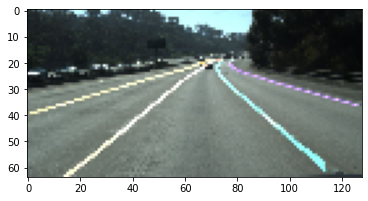

In [ ]:
image = plt.imread('1*b3HiwPg69Rw0L5iIMQMXOw.jpeg')
image = cv2.resize(image, (128, 64))
plt.imshow(image);

In [ ]:
R_np = R.numpy()

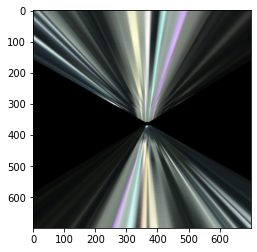

In [ ]:
plt.imshow(cv2.warpPerspective(image, R_np, dsize=(700, 700)))

As you can see it looks like a bird's eye view projection where lines are becoming parallel.

In [25]:
import torch
import torch.nn as nn


class HNet(nn.Module):
    def __init__(self):
        super(HNet, self).__init__()

        self.__conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.__bn1 = nn.BatchNorm2d(16)

        self.__conv2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.__bn2 = nn.BatchNorm2d(16)

        self.__conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.__bn3 = nn.BatchNorm2d(32)

        self.__conv4 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.__bn4 = nn.BatchNorm2d(32)

        self.__conv5 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.__bn5 = nn.BatchNorm2d(64)

        self.__conv6 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.__bn6 = nn.BatchNorm2d(64)

        self.__ln1 = nn.Linear(8192, 1024)
        self.__bn7 = nn.BatchNorm1d(1024)

        self.__ln2 = nn.Linear(1024, 6)

        self.__relu = nn.ReLU(inplace=True)
        self.__maxpool = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        x = self.__conv1(x)
        x = self.__relu(self.__bn1(x))
        x = self.__conv2(x)
        x = self.__relu(self.__bn2(x))
        x = self.__maxpool(x)

        x = self.__conv3(x)
        x = self.__relu(self.__bn3(x))
        x = self.__conv4(x)
        x = self.__relu(self.__bn4(x))
        x = self.__maxpool(x)

        x = self.__conv5(x)
        x = self.__relu(self.__bn5(x))
        x = self.__conv6(x)
        x = self.__relu(self.__bn6(x))
        x = self.__maxpool(x)

        x = x.view(x.size(0), -1)
        x = self.__relu(self.__bn7((self.__ln1(x))))
        x = self.__ln2(x)

        return x

Finally, we need to implement the loss to fit the network. This is the most difficult part of the project. Homography loss should do the following:

1. Project ground truth trajectory to the new plane according to the homography to obtain $(x', y')$.
2. Perform polynomial fitting $x' = f(y')$. Your code should work correctly with 2-nd and 3-rd order polynomials. Polynomial fitting should be done with the closed-form solution: $w = (Y^TY)^{-1}Y^Tx$ to be able to pass a gradient through. 
3. Compute back projection with the inverse homography.
4. Compute loss between back projected $\hat{x}$ and ground truth $x$.

The full description can be found in the [LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

**IMPORTANT NOTES**

* To fit the polynomial you need to compute the inverse matrix. Computation of the inverse is computation unstable operation. With the help of the SVD you can compute pseudo-inverse matrix: $(X^TX)^{-1}X^T$. In torch this function is called `torch.pinverse`.
* After projection use of the raw $y'$ can be impractical. The features for the polynomial fitting could have a high correlation and therefore solution can be unstable. At first, you need to map $y'$ to some fixed size segment and only then perform a fit.
* After projection some points can occur on the other side of image (bottom part of the projection in the example above). You may want to exclude them, because otherwise polynomial is not going to have much sense and gradients can have a dramatically large values. Positive $w$ in homogeneous coordinates indicates that point is on the wrong side.
* If use the homography provided above, your ground truth should have the same scale, as an image
* Every division in your network is a potential place to obtain `nan` in gradients. Use the following trick to obtain less divisions:
after computing the projection, remember the $w$. Then, before the back projection, multiply your vector by $w$. After back projection you will see that $w$ is equal to 1. So you don't need to devide your vector by $w$.
* You correction to the initial homography could be very big and can completely spoil the homography. So you may need to scale the output of the last layer in the HNet to obtain a smaller corrections.


In [26]:
class HomographyLoss(object):
    def hnet_loss_single(self, pts_gt, trans_coef):

        pts_gt = pts_gt.view(-1, 3)
        trans_coef = trans_coef.view(6)
        mult = torch.tensor([1e-02, 1e-01, 1e-01,  1e-01, 1e-01,1e-03]).type(torch.float32)
        trans_coef = trans_coef * mult
        trans_coef = torch.cat([trans_coef, torch.tensor([1.0]).type(torch.FloatTensor)])
      
        H_indices = torch.tensor([[0], [1], [2], [4], [5], [7], [8]], requires_grad=False)

        R = torch.tensor([-2.0484e-01, -1.7122e+01, 3.7991e+02, -1.6969e+01, 3.7068e+02, -4.6739e-01, 0.0000e+00]).type(torch.FloatTensor)
        H = torch.zeros(9, dtype=torch.float32)
        H[H_indices[:, 0]] = R + trans_coef 
       
        H = torch.reshape(H, shape=[3, 3])       
        
        pts_gt = pts_gt[pts_gt[:,2]==1]

        pts_gt = pts_gt.view(-1, 3).to(torch.float32).t()  # (3 * n)
        
        
        pts_projected = torch.mm(H, pts_gt) 
        if pts_gt.shape[1]<3:
            return 1.0
        
        pts_projected = torch.div(pts_projected, pts_projected[2,:])
        
        # least squares closed-form solution
        X = pts_projected[0, :].view(-1, 1)  # (n * 1)
        Y = pts_projected[1, :].view(-1, 1)  # (n * 1)
        #print("X+++++++++++++",X,"Y+++++++++++++++++",Y)
        
        Y_mat = torch.cat([torch.pow(Y, 2), Y, torch.ones_like(Y, dtype=torch.float32)], dim=1)  # (n * 4)
        
        w = torch.matmul(torch.matmul(torch.linalg.inv(torch.matmul(Y_mat.T, Y_mat)), Y_mat.T), X)
        # re-projection and compute loss

        x_pred = torch.mm(Y_mat, w)  # (n * 1)
        pts_pred = torch.cat([x_pred, Y, torch.ones_like(Y, dtype=torch.float32)], dim=1).t()  # (3 * n)

        pts_back = torch.mm(torch.linalg.inv(H), pts_pred)
        pts_back = torch.div(pts_back, pts_back[2,:])

        #print(pts_projected, pts_back)

        loss = torch.mean(torch.pow(pts_gt[0, :] - pts_back[0, :], 2))
        return loss
    

    def hnet_loss(self, pts_batch, coef_batch):
        
        pts_batch = pts_batch
        coef_batch = coef_batch

        batch_size = coef_batch.size()[0]

        loss_acc = torch.zeros(batch_size, dtype=torch.float64)

        for i in range(batch_size):
            
            loss_acc[i] = self.hnet_loss_single(pts_batch[i], coef_batch[i])
            
        #loss = loss_acc[~torch.isnan(loss_acc)].mean()
        return loss
    
    
    def hnet_loss_two_lines(self, pts_batch, coef_batch):
        
        pts_batch = pts_batch
        coef_batch = coef_batch

        batch_size = coef_batch.size()[0]

        loss_acc = torch.zeros(batch_size, dtype=torch.float64)
        
        for i in range(batch_size):
            pts_size = pts_batch.size()[1]
            loss_line = torch.zeros(pts_size, dtype=torch.float64)
            for k, line in enumerate(pts_batch[i]):
                line = line.T
                line = line[line[:,0]>0]
                line = torch.cat((line, torch.ones(line.size(0),1)),1)
                loss_one_line = self.hnet_loss_single(line, coef_batch[i])
                loss_line[k]=loss_one_line
            #loss_acc[i] = loss_line[~torch.isnan(loss_line)].mean()
            loss_acc[i] = loss_line.mean()
        #loss = loss_acc[~torch.isnan(loss_acc)].mean()
        loss = loss_acc.mean()
        #print(loss)
        return loss

Finally, train the homography net with the 2-nd order polynomial fitting (you can 3-rd order but we found out that it is much easier to train h-net with the 2-nd order polynomials).

We found out that SGD fits much better for this architectures. Adam (and momentums inside) can ruin the weights because of the discontinuities in the target function surface.

Demonstrate the difference in homography loss between h-net and provided fixed homography on the validation samples.

Let's load the dataset and split it into train and validation

In [27]:
dataset = HomographyPredictionDataset("gdrive/MyDrive/Colab Notebooks/CV/tusimple/")
train_set, val_set = torch.utils.data.random_split(dataset, [3216, 410])
random_sample = dataset[random.randint(0, len(train_set) - 1)]

In [ ]:
image = random_sample[0][0]
lane_pair = random_sample[1]
lane_cnt = len(lane_pair)

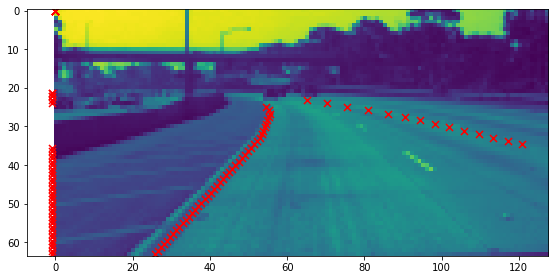

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.imshow(image)
for i in range(lane_cnt):
    plt.scatter(lane_pair[i][0, :], lane_pair[i][1, :], marker="x", s=50, color="red")
plt.show()

Let's see how many examples we have in the validation and train datasets

In [ ]:
len(val_set), len(train_set)

(410, 3216)

In [ ]:
batch_size = 6
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

In [ ]:
def init_all(model, init_func, *params, **kwargs):
    for p in model.parameters():
        init_func(p, *params, **kwargs)

model = HNet()
init_all(model, torch.nn.init.constant_, 0.001)

epoch = 10
optimizer = optim.SGD(model.parameters(), lr=0.01)

for ep in range(epoch):
    bgloss = []
    model.train()
    for img, label in tqdm(train_loader):
        img = torch.FloatTensor(img)
          
        gt_labels = torch.FloatTensor(label)
        out = model(img)
        
        loss_fn = HomographyLoss()
        loss = loss_fn.hnet_loss_two_lines(gt_labels,out)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        bgloss.append(loss.cpu().detach().numpy())
        mn_loss = np.mean(bgloss)
    model.eval()
    
    with torch.no_grad():
        val_loss = []
        for img, label in tqdm(val_loader):
            img = torch.FloatTensor(img)

            gt_labels = torch.FloatTensor(label)
            out = model(img)

            loss_fn = HomographyLoss()
            loss = loss_fn.hnet_loss_two_lines(gt_labels,out)
            val_loss.append(loss.cpu().detach().numpy())
        
            val_mn_loss = np.mean(val_loss)
        
    print('Epoch', ep, 'Train_Loss', mn_loss.round(decimals=5), 'Val Loss', val_mn_loss.round(decimals=5))
    print('-----------------------------------------')

torch.save(model.state_dict(), os.path.join("/content/gdrive/MyDrive/", "hnet-model.pkl"))

100%|██████████| 68/68 [00:10<00:00,  6.38it/s]


Epoch 0 Train_Loss 0.29091 Val Loss 0.26091
-----------------------------------------


100%|██████████| 68/68 [00:10<00:00,  6.63it/s]


Epoch 1 Train_Loss 0.26562 Val Loss 0.26089
-----------------------------------------


100%|██████████| 68/68 [00:10<00:00,  6.38it/s]


Epoch 2 Train_Loss 0.27966 Val Loss 0.26089
-----------------------------------------


100%|██████████| 68/68 [00:10<00:00,  6.29it/s]


Epoch 3 Train_Loss 0.29079 Val Loss 0.2609
-----------------------------------------


100%|██████████| 68/68 [00:09<00:00,  6.90it/s]


Epoch 4 Train_Loss 0.2653 Val Loss 0.26089
-----------------------------------------


100%|██████████| 68/68 [00:10<00:00,  6.70it/s]


Epoch 5 Train_Loss 0.29667 Val Loss 0.26103
-----------------------------------------


100%|██████████| 68/68 [00:10<00:00,  6.25it/s]


Epoch 6 Train_Loss 0.28384 Val Loss 0.26087
-----------------------------------------


100%|██████████| 68/68 [00:12<00:00,  5.63it/s]


Epoch 7 Train_Loss 0.26582 Val Loss 0.26091
-----------------------------------------


100%|██████████| 68/68 [00:12<00:00,  5.58it/s]


Epoch 8 Train_Loss 0.27315 Val Loss 0.26086
-----------------------------------------


100%|██████████| 68/68 [00:12<00:00,  5.59it/s]


Epoch 9 Train_Loss 0.26801 Val Loss 0.26089
-----------------------------------------


In [ ]:
model.load_state_dict(torch.load("/content/gdrive/MyDrive/hnet-model.pkl"))
model.eval();

In [ ]:
random_sample = dataset[random.randint(0, len(val_set) - 1)]
image = random_sample[0][0]
lane_pair = random_sample[1]
lane_cnt = len(lane_pair)

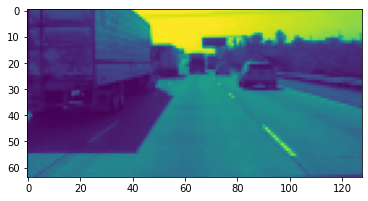

In [ ]:
plt.imshow(image);

In [ ]:
x = torch.FloatTensor(random_sample[0])
x = x.unsqueeze(0)
out = model(x)

In [ ]:
transformation_coeffcient = torch.cat(
    [out[0], torch.tensor([1.0], dtype=torch.float64).to(DEVICE)], -1
).type(torch.float64)
mult = (torch.tensor([1e-02, 1e-01, 1e-01, 1e-01, 1e-01, 1e-03, 1]).type(torch.float32).to(DEVICE)
)
transformation_coeffcient = transformation_coeffcient * mult
print(transformation_coeffcient)
H_indices = torch.tensor([[0], [1], [2], [4], [5], [7], [8]], requires_grad=False).to(DEVICE)
R = torch.tensor([-2.0484e-01, -1.7122e01, 3.7991e02, -1.6969e01, 3.7068e02, -4.6739e-02, 0.0000e00]).to(DEVICE)
result = torch.zeros(9, dtype=torch.float64).to(DEVICE)
result[H_indices[:, 0]] = R + transformation_coeffcient
H = torch.reshape(result, shape=[3, 3])

tensor([-7.0275e-04,  2.4755e-03,  1.6857e-04,  2.2914e+00,  4.7851e-02,
        -4.5941e-03,  1.0000e+00], dtype=torch.float64, grad_fn=<MulBackward0>)


In [ ]:
R = R.to(DEVICE)

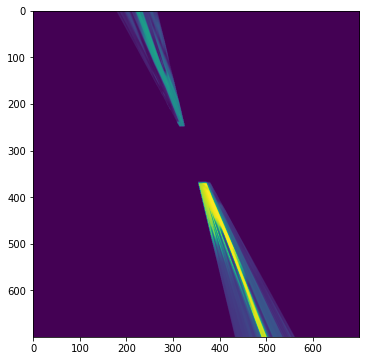

In [ ]:
img = cv2.resize(image, HNET_DEFAULT_SIZE, interpolation=cv2.INTER_LINEAR)
plt.figure(figsize=(6, 6))
plt.imshow(cv2.warpPerspective(img, H.detach().cpu().numpy(), dsize=(700, 700)));

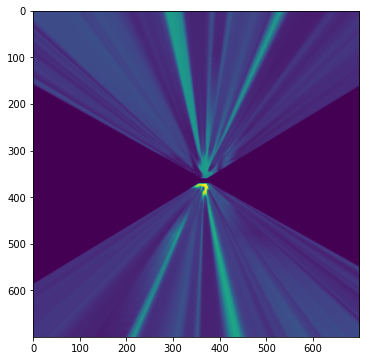

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(cv2.warpPerspective(img, R_np, dsize=(700, 700)));

# Complete Pipeline

Now you need to implement a class that takes image and a set of $y$ coordinates as an input and returns the $x$ coordinate for each lane in this image.

It should contain the following steps:

1. Apply segmentation network to the image
2. Run DBSCAN over the embeddings for those pixels that are lanes.
3. Apply h-net to the image
4. Project pixel coordinates with the predicted homograpgy
5. Fit the 3-rd order polynomial
6. Predict the lane position for each provided $y$ (you should project this first).
7. Compute back projection and return the positions of $x$ for each lane.

Note: if you weren't able to train the H-Net, you can use the fixed homography here.

Let's import libreries

In [28]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random


from collections import defaultdict
from sklearn.cluster import DBSCAN

In [29]:
def same_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

same_seed(42)

In [30]:
def minmax_scale(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)

    output_arr = (arr - min_val) * 255.0 / (max_val - min_val)
    return output_arr

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Reference: Towards End-to-End Lane Detection: an Instance Segmentation
Approach
https://arxiv.org/pdf/1802.05591.pdf

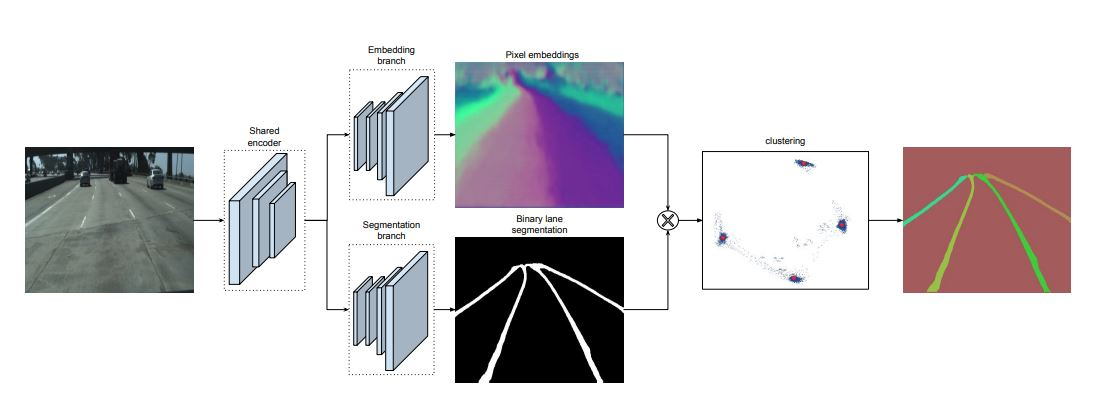

LaneNet architecture. It consists of two branches. The segmentation branch (bottom) is trained to produce a binary lane mask. The embedding
branch (top) generates an N-dimensional embedding per lane pixel, so that embeddings from the same lane are close together and those from different
lanes are far in the manifold. For simplicity we show a 2-dimensional embedding per pixel, which is visualized both as a color map (all pixels) and as
points (only lane pixels) in a xy grid. After masking out the background pixels using the binary segmentation map from the segmentation branch, the lane
embeddings (blue dots) are clustered together and assigned to their cluster centers (red dots).

In [32]:
# https://github.com/IvanVassi/LaneNet-with-homography/blob/main/3_Final_pipeline.ipynb
# https://github.com/IvanVassi/LaneNet-with-homography/blob/main/lane_cluster_hnet.py

DEFAULT_SIZE = (512, 256)


class LaneDetector:
    def __init__(self, image, modelh, modelseg, degree=3):
        self.__image = image
        self.__degree = degree
        self.__modelh = modelh
        self.__modelseg = modelseg

    def __segment(self):
        '''
        Apply segmentation network to the image
        '''
        threshold = 0.75
        img = cv2.resize(self.__image, DEFAULT_SIZE, interpolation=cv2.INTER_LINEAR)
        img = img.astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = torch.from_numpy(img).float()
        img = img.permute(2, 0, 1)
        img = img.unsqueeze(0)
        segmentation, embeddings = self.__modelseg(img)

        binary_mask = torch.argmax(F.softmax(segmentation, dim=1), dim=1, keepdim=True)
        binary_mask = segmentation.data.cpu().numpy()
        binary_mask = binary_mask.squeeze()

        exp_mask = np.exp(binary_mask - np.max(binary_mask, axis=0))
        binary_mask = exp_mask / exp_mask.sum(axis=0)
        threshold_mask = binary_mask[1, :, :] > threshold
        threshold_mask = threshold_mask.astype(np.uint8)
        threshold_mask = threshold_mask  # *255

        kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(1, 1))
        cv2.rectangle(threshold_mask, (0, 0), (512, 100), (0, 0, 0), thickness=-1)
        threshold_mask = cv2.dilate(threshold_mask, kernel, iterations=1)
        mask = cv2.connectedComponentsWithStats(threshold_mask, connectivity=4, ltype=cv2.CV_32S)
        output_mask = np.zeros(threshold_mask.shape, dtype=np.uint8)
        
        for label in np.unique(mask[1]):
            if label == 0:
                continue
            labelMask = np.zeros(threshold_mask.shape, dtype="uint8")
            labelMask[mask[1] == label] = 255
            numPixels = cv2.countNonZero(labelMask)
            if numPixels > 500:
                output_mask = cv2.add(output_mask, labelMask)
        output_mask = output_mask / 255

        self.__embedding = embeddings.squeeze().data.cpu().numpy()
        self.__binary = output_mask

        fig, ax1 = plt.subplots(figsize=(10, 15))
        ax1.imshow(self.__binary)
        ax1.title.set_text('Segmentation output')
        return output_mask, embeddings

    def __get_lane_area(self):
        idx = np.where(self.__binary.T == 1)
        lane_area = []
        lane_idx = []
        for i, j in zip(*idx):
            lane_area.append(self.__embedding[:, j, i])
            lane_idx.append((j, i))
        return np.array(lane_area), lane_idx

    def __cluster(self, prediction):
        '''
        Run DBSCAN over the embeddings for those pixels that are lanes.
        '''
        clustering = DBSCAN(eps=0.5, min_samples=500).fit(prediction)
        return clustering.labels_

    def __get_instance_masks(self):
        gt_img = self.__image
        gt_img = cv2.resize(gt_img, HNET_DEFAULT_SIZE, interpolation=cv2.INTER_LINEAR)
        gt_img = gt_img * (1.0 / gt_img.max())
        gt_img = np.rollaxis(gt_img, 2, 0)
        hnet_im = np.expand_dims(gt_img, 0)
        hnet_im = torch.FloatTensor(hnet_im)

        out = self.__modelh(hnet_im)
        transformation_coeffcient = torch.cat([out[0], torch.tensor([1.0], dtype=torch.float32)], -1).type(torch.float32)
        mult = torch.tensor([1e-02, 1e-01, 1e-01,  1e-01, 1e-01,1e-03,1]).type(torch.float32)
        transformation_coeffcient = transformation_coeffcient*mult
        H_indices = torch.tensor([[0], [1], [2], [4], [5], [7], [8]], requires_grad=False)
        R = torch.tensor([-2.0484e-01,     -1.7122e+01,     3.7991e+02,     -1.6969e+01,     3.7068e+02,     -4.6739e-02,  0.0000e+00])
        result = torch.zeros(9, dtype=torch.float32)
        result[H_indices[:, 0]] = R + transformation_coeffcient 
        H = torch.reshape(result, shape=[3, 3])

        xx = self.__segment()
        lane_area, lane_idx = self.__get_lane_area()
        lane_idx = np.array(lane_idx)

        image = self.__image
        mask = np.zeros_like(image)
        segmentation_mask = np.zeros_like(image)
        if len(lane_area.shape) != 2:
            return image
        labels = self.__cluster(lane_area)

        _, unique_label = np.unique(labels, return_index=True)
        unique_label = labels[np.sort(unique_label)]
        color_map = {}
        polynomials = defaultdict(list)
        for index, label in enumerate(unique_label):
            color_map[label] = index
        for index, label in enumerate(labels):
            if len(polynomials[label]) == 0:
                polynomials[label].append([lane_idx[index][0], lane_idx[index][1], 1])
            elif 30 > lane_idx[index][1] - polynomials[label][-1][1] > 5:
                polynomials[label].append([lane_idx[index][0], lane_idx[index][1], 1])

        x_for_ypos = []
        for label in polynomials.keys():
            a = (np.array(polynomials[label])[:, 1] / 4,
                np.array(polynomials[label])[:, 0] / 4,)
            a = np.array(a, np.float32)
            a = torch.FloatTensor(a)
            line = torch.cat((a.T, torch.ones(a.size(1), 1)), 1)

            if line.shape[0] < 5:
                continue

            line_projected = torch.mm(H, line.T)
            line_projected = torch.div(line_projected, line_projected[2, :])

            X = line_projected[0, :].view(-1, 1)
            Y = line_projected[1, :].view(-1, 1)

            if self.__degree == 2:
                Y_mat = torch.cat([torch.pow(Y, 2), Y, torch.ones_like(Y, dtype=torch.float32)], dim=1)
            else:
                Y_mat = torch.cat([torch.pow(Y, 3), torch.pow(Y, 2), Y, torch.ones_like(Y, dtype=torch.float32),], dim=1,)

            w = torch.matmul(torch.matmul(torch.pinverse(torch.matmul(Y_mat.T, Y_mat)), Y_mat.T), X)
            x_pred = torch.mm(Y_mat, w)

            line_pred = torch.cat([x_pred, Y, torch.ones_like(Y, dtype=torch.float32)], dim=1).t()
            line_back = torch.mm(H.pinverse(), line_pred)
            line_back = torch.div(line_back, line_back[2, :]).T
            line_back = line_back[line_back[:, 0] > 0]

            x_for_ypos.append(line_back.detach().cpu().numpy())

            if line_back.shape[0] < 10:
                continue

        lane_cnt = len(x_for_ypos)

        fig, ax2 = plt.subplots(figsize=(10, 15))
        ax2.imshow(self.__image)
        ax2.title.set_text('Lane predictions')


        for i in range(lane_cnt):
            plt.scatter(
                x_for_ypos[i][:, 0] * 10,
                x_for_ypos[i][:, 1] * 11.25,
                marker="x",
                s=50)
        plt.xlim([0, 1280])
        plt.ylim([720, 0])

        plt.show()

        return x_for_ypos

    def __call__(self):
        return self.__get_instance_masks()

In [33]:
model_lnet = ENet()
model_lnet.load_state_dict(torch.load("/content/gdrive/MyDrive/Colab Notebooks/CV/enet-model.pkl"))
model_lnet.eval()

model_hnet = HNet()
model_hnet.load_state_dict(torch.load("/content/gdrive/MyDrive/hnet-model.pkl"))
model_hnet.eval();

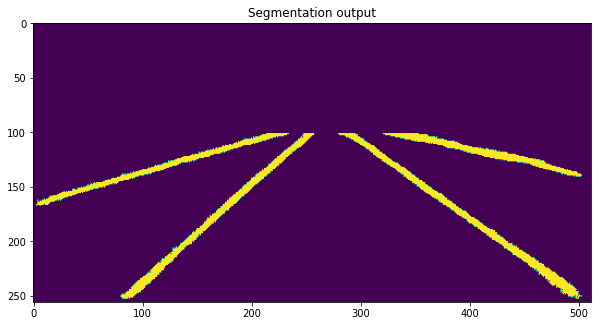

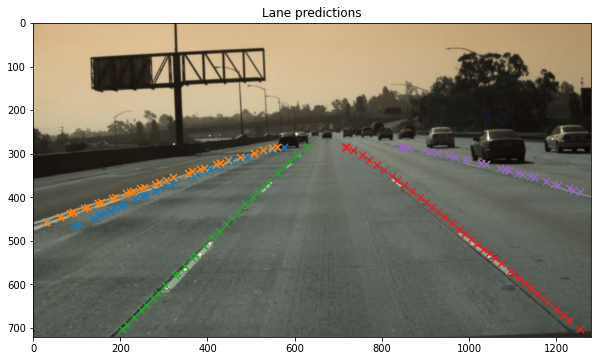

In [34]:
image = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/CV/tusimple/clips/0313-1/39120/20.jpg", cv2.IMREAD_COLOR)
cluster = LaneDetector(image=image, degree=2, modelh=model_hnet, modelseg=model_lnet)
x_preds = cluster();

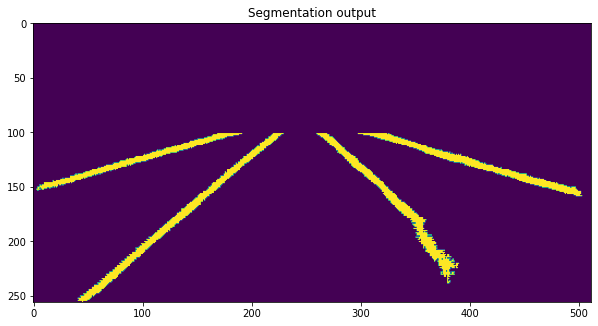

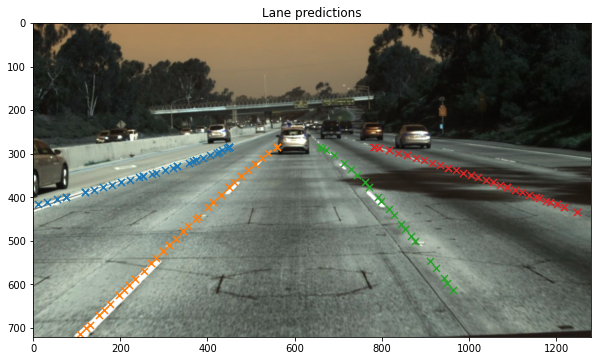

In [37]:
image = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/CV/tusimple/clips/0313-2/27180/20.jpg", cv2.IMREAD_COLOR)
cluster = LaneDetector(image=image, degree=2, modelh=model_hnet, modelseg=model_lnet)
x_preds = cluster();

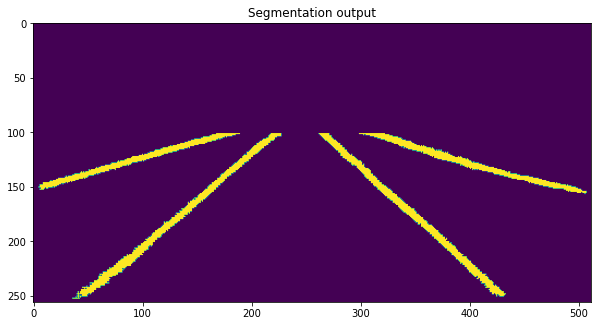

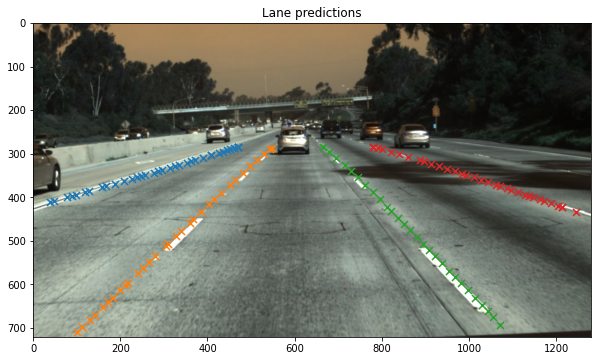

In [42]:
image = cv2.imread("/data/tusimple/clips/0313-2/27180/10.jpg", cv2.IMREAD_COLOR)
cluster = LaneDetector(image=image, degree=2, modelh=model_hnet, modelseg=model_lnet)
x_preds = cluster();

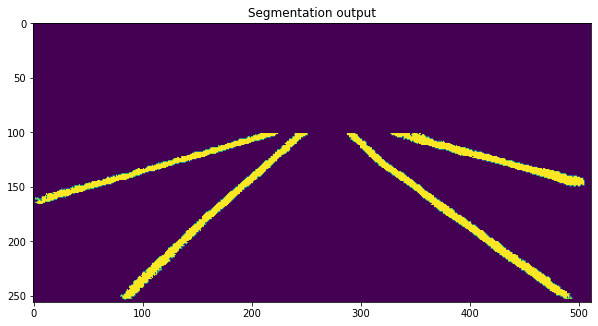

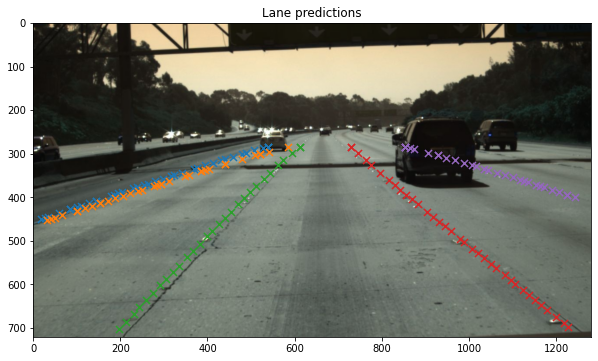

In [44]:
image = cv2.imread("/data/tusimple/clips/0313-1/10460/15.jpg", cv2.IMREAD_COLOR)
cluster = LaneDetector(image=image, degree=2, modelh=model_hnet, modelseg=model_lnet)
x_preds = cluster();

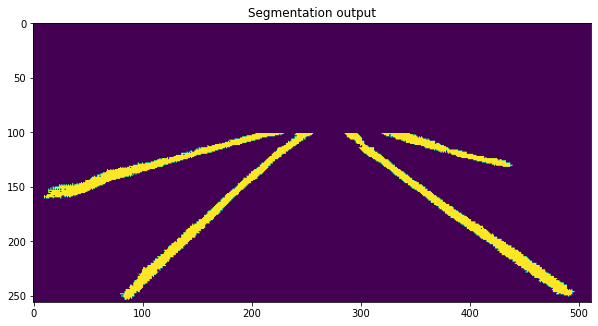

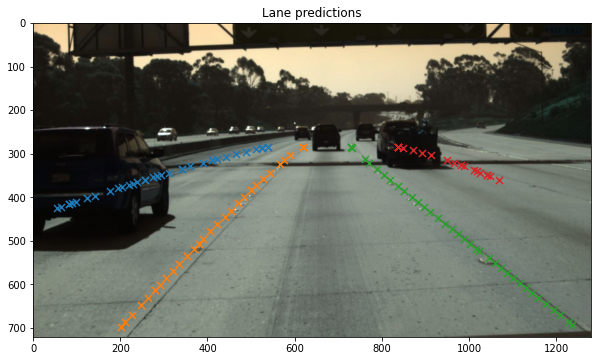

In [45]:
image = cv2.imread("/data/tusimple/clips/0313-1/11360/19.jpg", cv2.IMREAD_COLOR)
cluster = LaneDetector(image=image, degree=2, modelh=model_hnet, modelseg=model_lnet)
x_preds = cluster();